# EDA

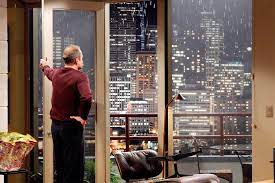

In [1]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv('data/eda.csv')


In [ ]:
numerical_features = [
    'bedrooms',
    'bathrooms',
    'sqft_living',
    'sqft_lot',
    'floors',
    'sqft_above',
    'sqft_basement',
    'sqft_living15',
    'sqft_lot15',
    'price',
    ]

categorical_features = [
    'condition',
    'yr_built',
    'yr_renovated',
    'zipcode',
    'grade'
]

In [ ]:
columns = [
    'bedrooms',
    'bathrooms',
    'sqft_living',
    'sqft_lot',
    'floors',
    'sqft_above',
    'sqft_basement',
    'sqft_living15',
    'sqft_lot15',
    'price',
    'condition',
    'yr_built',
    'yr_renovated',
    'zipcode',
    'grade'
    ]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    df[columns].corr(),
    cmap='RdBu_r',
    linecolor='white',
    linewidth=1,
    annot=True,
    fmt='.1f',
    vmin=-1,
    vmax=1,
    ax=ax
)

plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

In [ ]:
#Explore
df.describe()
df.isna().sum()
df[df['lat'].isna()]
np.sort(df['lat'].unique())
np.sort(df['lat'].value_counts())

In [ ]:
#Analysis
renovated = df[df['yr_renovated'] > 0]
not_renovated = df[(df['yr_renovated'] == 0) | (df['yr_renovated'].isna())]
print('Num of renovated:', renovated.shape[0])
print('Num of not renovated:', not_renovated.shape[0])

has_basement = df[df['sqft_basement']>0]
no_basement = df[(df['sqft_basement'] == 0) | (df['sqft_basement'].isna())]
print('Average price with basement: ', round(has_basement['price'].mean()))
print('Average price with basement: ', round(no_basement['price'].mean()))

Apartments = df.duplicated(subset=['lat', 'long'], keep=False)
Apartments.any()
df[Apartments].sort_values(['lat', 'long'])

In [3]:
#Cleaning - yr_renovated - change dtype to date (Y) - replace 0 to np.nan so 0 will be NaT
df['yr_renovated'] = pd.to_datetime(df['yr_renovated'].replace(0, np.nan), format='%Y')

#Cleaning - transform - remove 0. from the end of yr_renovated and change to int
df['yr_renovated'] = (df['yr_renovated']/10).astype(int)

ValueError: unconverted data remains when parsing with format "%Y": "0", at position 1. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [ ]:
df.head(5)

In [4]:
#Cleaning - rename columns
df = df.rename(columns={'view': 'num_of_views'})

#Cleaning - transform - Bathroom round up to the nearest half
df['bathrooms'].value_counts().sort_index()
df['bathrooms'] = np.ceil(df['bathrooms']*2)/2
df.head(5)

#Cleaning - transform -remove bedroom outliers
outlier_index = df.query('bedrooms == 33').index
df = df.drop(outlier_index)

#Cleaning - transforms - gets rows where living is bigger than lot and transforms lot = living
lot_bigger_living = df['sqft_living'] > df['sqft_lot']
df.loc[lot_bigger_living, 'sqft_lot'] = df.loc[lot_bigger_living, 'sqft_living']

#Cleaning - transform - graade column to classes and groups
df['grade_class'] = df['grade'].map({
    3:'Below minimum building standards, often cabins or very basic structures.',
    4:'Older and low-quality; likely below modern building codes.',
    5:'Simple, low-cost designs with basic workmanship.',
    6:'Meets current code but is still on the low end of materials and design.',
    7:'Average build quality, commonly found in standard subdivisions.',
    8:'Slightly above average, better materials and finish quality.',
    9:'Enhanced architectural design with improved interior and exterior finishes.',
    10:'High-quality homes with high-end features and finishes.',
    11:'Custom-designed homes with rich finishes and luxury amenities.',
    12:'Very high-end custom homes with premium materials and detailing.',
    13:'Mansion-level, custom-built for luxury with top-tier fixtures and finishes',})
df['grade_class_group'] = df['grade'].map({
    3:'Low Grade (3-5)',
    4:'Low Grade (3-5)',
    5:'Low Grade (3-5)',
    6:'Medium Grade (6-9)',
    7:'Medium Grade (6-9)',
    8:'Medium Grade (6-9)',
    9:'Medium Grade (6-9)',
    10:'High Grade (10-13)',
    11:'High Grade (10-13)',
    12:'High Grade (10-13)',
    13:'High Grade (10-13)'}) 

In [5]:
#Clean - missing values - fill yr_renovated column with 0 because there are much more that are no renovated and hard to predict the year
df['yr_renovated'] = df['yr_renovated'].fillna(0.0)
df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

#Clean - missing values - fill sqft_basement column with 0 because you cannot guess the size even if it has one.
df['sqft_basement'] = df['sqft_basement'].fillna(0.0)

#Cleaning - missing values - fill num_of_views with mode
df['num_of_views'] = df['num_of_views'].fillna(df['num_of_views'].mode()[0])

#Cleaning - waterfront - Fill waterfront with Zips with or without waterfront views to 0 or 1:
no_waterfront_zip = ((df['zipcode'].isin([98001, 98002, 98003, 98005, 98007, 98010, 98014, 98019, 98022, 98023, 98024, 98027, 
                                          98028, 98029, 98030, 98031, 98032, 98038, 98042, 98045, 98053, 98055, 
                                          98056, 98058, 98059, 98065, 98072, 98077, 98092, 98106, 98108, 98122, 98133, 98146, 
                                          98148, 98155, 98166, 98168, 98178, 98188, 98198, 98011, 98052])) 
                        & (df['waterfront'].isna()))
with_waterfront_zip = ((df['zipcode'].isin([98102, 98103, 98105, 98107, 98109, 98112, 98115, 98116, 98117,
                                              98118, 98119, 98125, 98126, 98136, 98144, 98177, 98199, 98004, 98006, 
                                              98008, 98033, 98034, 98039, 98040, 98074, 98075, 98070])) 
                                              & (df['waterfront'].isna()))
df.loc[no_waterfront_zip, 'waterfront'] = 0
df.loc[with_waterfront_zip, 'waterfront'] = 1

In [6]:
#Cleaning - waterfront - change dtype
df['waterfront'] = df['waterfront'].astype(bool)

#Cleaning - yr_built - change dtype to date (Y)
df['yr_built'] = pd.to_datetime(df['yr_built'], format='%Y')

#Cleaning - yr_built - change dtype to date
df['date'] = pd.to_datetime(df['date'])

#Cleaning - bedrooms - change dtype to int
df['bedrooms'] = df['bedrooms'].astype(int)

#Cleaning - num_of_views - change dtype to int
df['num_of_views'] = df['num_of_views'].astype(int)

#Cleaning - price - change dtype to int
df['price'] = df['price'].astype(int)


In [ ]:
df['sqft_living'].describe()

In [ ]:
df['sqft_living'].sort_values(ascending=False)


Lowest = 370
Highest = 13540

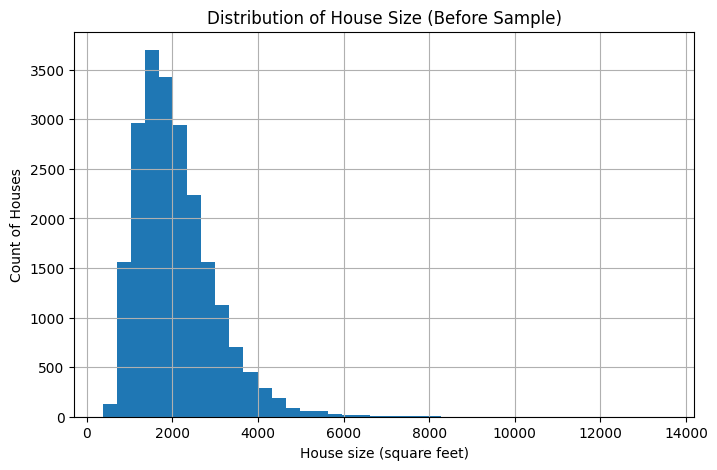

In [7]:
plt.figure(figsize=(8, 5))
df['sqft_living'].hist(bins=40)
plt.xlabel('House size (square feet)')
plt.ylabel('Count of Houses')
plt.title('Distribution of House Size (Before Sample)')
plt.show()

In [126]:
# Define your lower & upper bounds
lower = 300
upper = 4000
# Filter the DataFrame
df_sqft_living_sample = df[(df['sqft_living'] >= lower) & (df['sqft_living'] <= upper)].reset_index()
print(f"Original rows: {len(df)}")
print(f"Sample rows: {len(df_sqft_living_sample)}")
print((len(df_sqft_living_sample)/len(df))*100)

Original rows: 21596
Sample rows: 20814
96.37895906649379


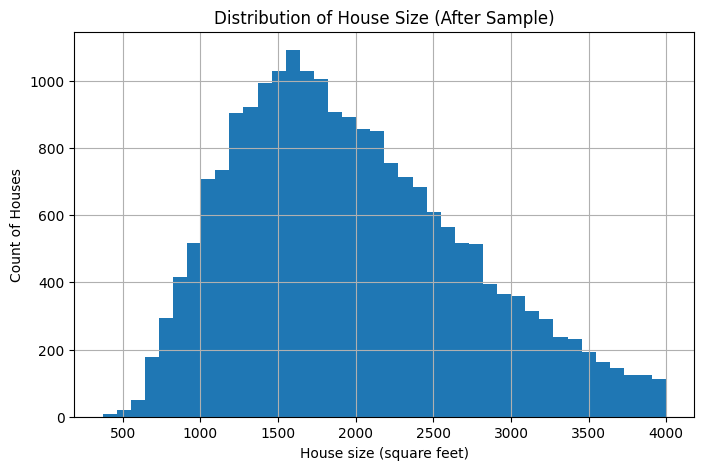

In [9]:
plt.figure(figsize=(8, 5))
df_sqft_living_sample['sqft_living'].hist(bins=40)
plt.xlabel('House size (square feet)')
plt.ylabel('Count of Houses')
plt.title('Distribution of House Size (After Sample)')
plt.show()

In [10]:
df_sqft_living_sample

,index,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,num_of_views,condition,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date,price,grade_class,grade_class_group
0,0,7129300520,3,1.000,1180.000,5650.000,1.000,False,0,3,...,0.000,98178,47.511,-122.257,1340.000,5650.000,2014-10-13,221900,"Average build quality, commonly found in stand...",Medium Grade (6-9)
1,1,6414100192,3,2.500,2570.000,7242.000,2.000,False,0,3,...,19910.000,98125,47.721,-122.319,1690.000,7639.000,2014-12-09,538000,"Average build quality, commonly found in stand...",Medium Grade (6-9)
2,2,5631500400,2,1.000,770.000,10000.000,1.000,False,0,3,...,0.000,98028,47.738,-122.233,2720.000,8062.000,2015-02-25,180000,Meets current code but is still on the low end...,Medium Grade (6-9)
3,3,2487200875,4,3.000,1960.000,5000.000,1.000,False,0,5,...,0.000,98136,47.521,-122.393,1360.000,5000.000,2014-12-09,604000,"Average build quality, commonly found in stand...",Medium Grade (6-9)
4,4,1954400510,3,2.000,1680.000,8080.000,1.000,False,0,3,...,0.000,98074,47.617,-122.045,1800.000,7503.000,2015-02-18,510000,"Slightly above average, better materials and f...",Medium Grade (6-9)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20809,21592,263000018,3,2.500,1530.000,1530.000,3.000,False,0,3,...,0.000,98103,47.699,-122.346,1530.000,1509.000,2014-05-21,360000,"Slightly above average, better materials and f...",Medium Grade (6-9)
20810,21593,6600060120,4,2.500,2310.000,5813.000,2.000,False,0,3,...,0.000,98146,47.511,-122.362,1830.000,7200.000,2015-02-23,400000,"Slightly above average, better materials and f...",Medium Grade (6-9)
20811,21594,1523300141,2,1.000,1020.000,1350.000,2.000,False,0,3,...,0.000,98144,47.594,-122.299,1020.000,2007.000,2014-06-23,402101,"Average build quality, commonly found in stand...",Medium Grade (6-9)
20812,21595,291310100,3,2.500,1600.000,2388.000,2.000,False,0,3,...,0.000,98027,47.535,-122.069,1410.000,1287.000,2015-01-16,400000,"Slightly above average, better materials and f...",Medium Grade (6-9)


In [ ]:
#Hypothesis
#1. Higher grade houses usually mean a larger house

# Calculate average price by grade
avg_size_by_grade = df.groupby('grade')['sqft_living'].mean().reset_index()

# Line plot
plt.figure(figsize=(7, 4))
sns.lineplot(x='grade', y='sqft_living', data=avg_size_by_grade)
plt.xlabel('Grade')
plt.ylabel('Average Size of House')
plt.title('Average Size by Grade')
plt.show()

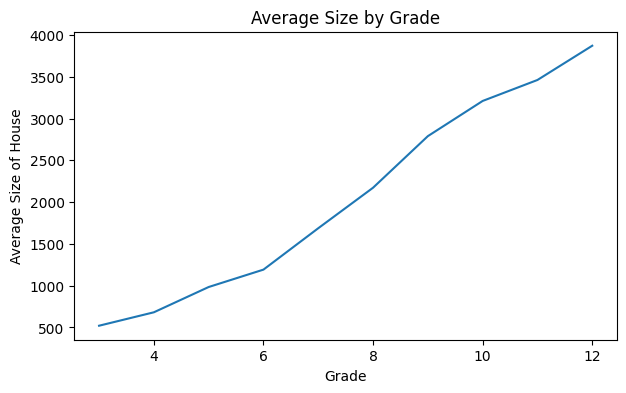

In [11]:
#Hypothesis
#1. Higher grade houses usually mean a larger house

# Calculate average price by grade
avg_size_by_grade = df_sqft_living_sample.groupby('grade')['sqft_living'].mean().reset_index()

# Line plot
plt.figure(figsize=(7, 4))
sns.lineplot(x='grade', y='sqft_living', data=avg_size_by_grade)
plt.xlabel('Grade')
plt.ylabel('Average Size of House')
plt.title('Average Size by Grade')
plt.show()

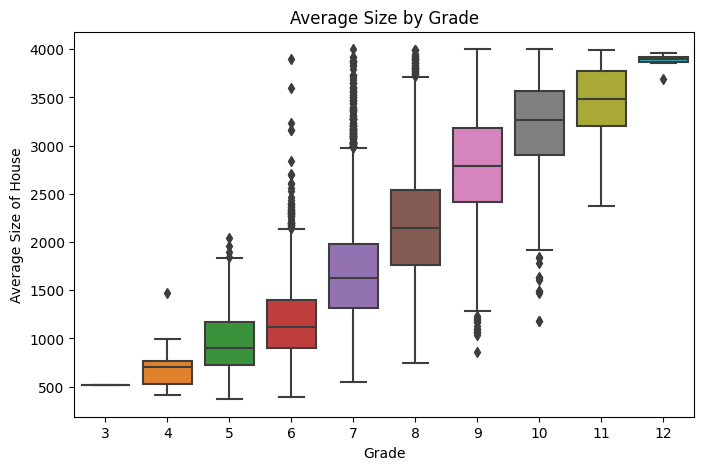

In [13]:
sns.boxplot(
    x='grade', 
    y='sqft_living', 
    data=df_sqft_living_sample)
plt.xlabel('Grade')
plt.ylabel('Average Size of House')
plt.title('Average Size by Grade')
plt.show()

Text(0.5, 1.0, 'Relationship bewteen Size of House and Grade Class')

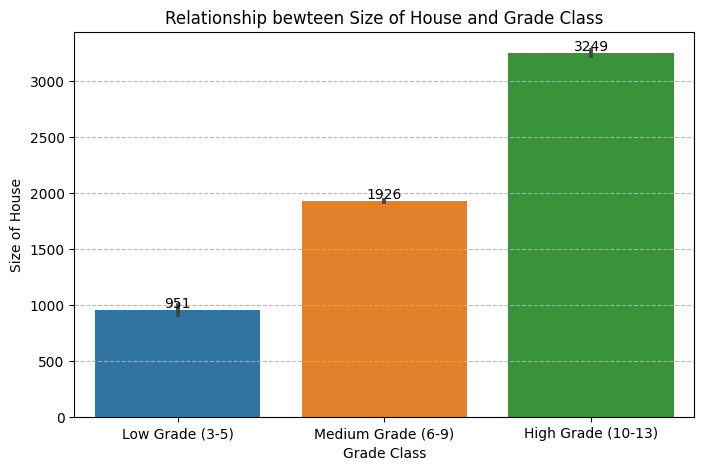

In [14]:
ax = sns.barplot(
    data=df_sqft_living_sample, 
    x='grade_class_group', 
    y='sqft_living',
    order=['Low Grade (3-5)', 'Medium Grade (6-9)', 'High Grade (10-13)'])

ax.bar_label(ax.containers[0], fmt='%.0f')
ax.grid(True, axis='y', linestyle='--', alpha=0.9)
plt.xlabel('Grade Class')
plt.ylabel('Size of House')
plt.title('Relationship bewteen Size of House and Grade Class')

In [15]:
#Both numeric & you assume equal intervals
print("Pearson:", df['grade'].corr(df['sqft_living'], method='pearson'))

#Categorical (Ordinal) + numeric, monotonic unsure if the steps between grades are perfectly equal - Better choice
print("Spearman:", df['grade'].corr(df['sqft_living'], method='spearman'))

Pearson: 0.7627760203230776
Spearman: 0.7162592821178124


In [16]:
current_year = pd.Timestamp.now().year
df['age_of_house'] = current_year - df['yr_built'].dt.year

df[['yr_built', 'age_of_house']].sort_values('age_of_house', ascending=False)

,yr_built,age_of_house
3878,1900-01-01,125
3973,1900-01-01,125
3915,1900-01-01,125
14,1900-01-01,125
5231,1900-01-01,125
...,...,...
20836,2015-01-01,10
20865,2015-01-01,10
20947,2015-01-01,10
20917,2015-01-01,10


In [ ]:
#df['age_of_house']
#df['age_bin'] = pd.cut(df['age_of_house'],
#                       bins=[0, 10, 20, 30, 40, 50, 100, 150],
#                       labels=['0–10', '10–20', '20–30', '30–40', '40–50', '50–100', '100+'])

age_count = df['age_of_house'].value_counts().sort_index()
age_count



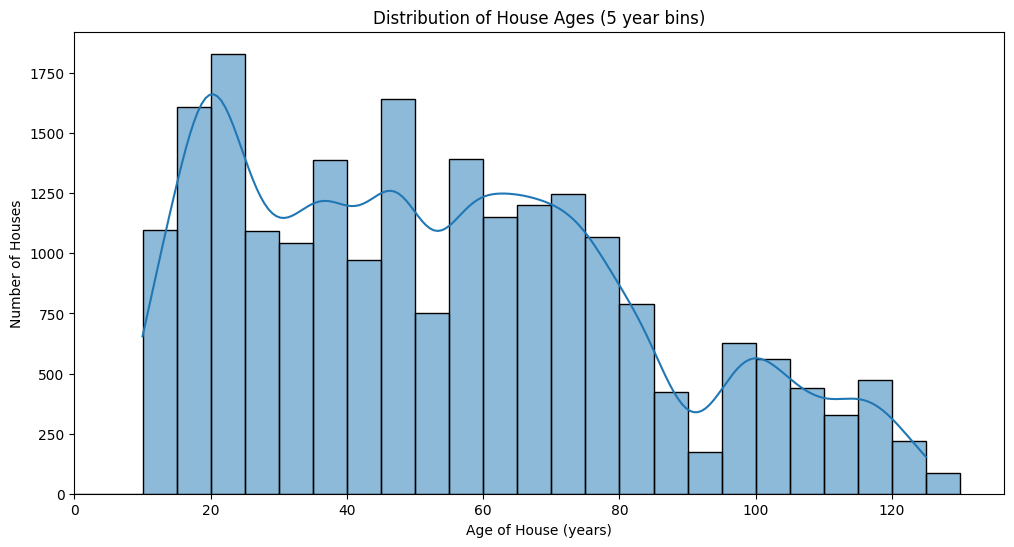

In [130]:
#Age of house spread
bar_bins = np.arange(0, 131, 5)
plt.figure(figsize=(12, 6))
sns.histplot(df['age_of_house'], bins=bar_bins, kde=True)
plt.xlabel('Age of House (years)')
plt.ylabel('Number of Houses')
plt.title('Distribution of House Ages (5 year bins)')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

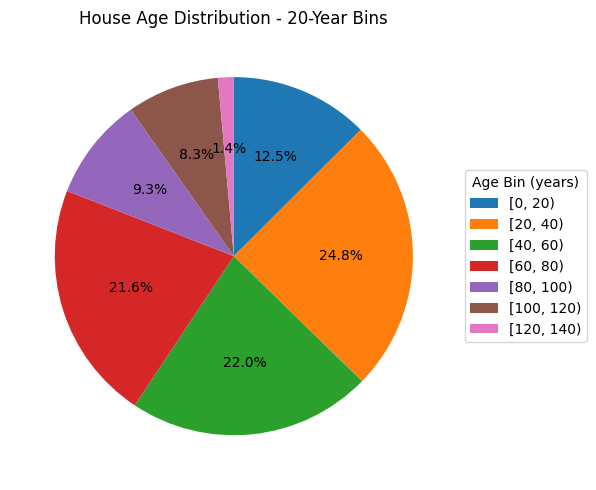

In [128]:
# Bin the data & count
pie_bins = np.arange(0, 141, 20)
df['age_bin'] = pd.cut(df['age_of_house'], bins=pie_bins, right=False)
age_bin_counts = df['age_bin'].value_counts().sort_index()

# Now plot the counts!
wedges, texts, autotexts = plt.pie(
    age_bin_counts.values,          # ✅ counts go here
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False
)

# Add legend with bin labels
plt.legend(
    wedges,
    age_bin_counts.index.astype(str),
    title='Age Bin (years)',
    loc='center left',
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.title('House Age Distribution - 20-Year Bins')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Relationship between house age and its Condition')

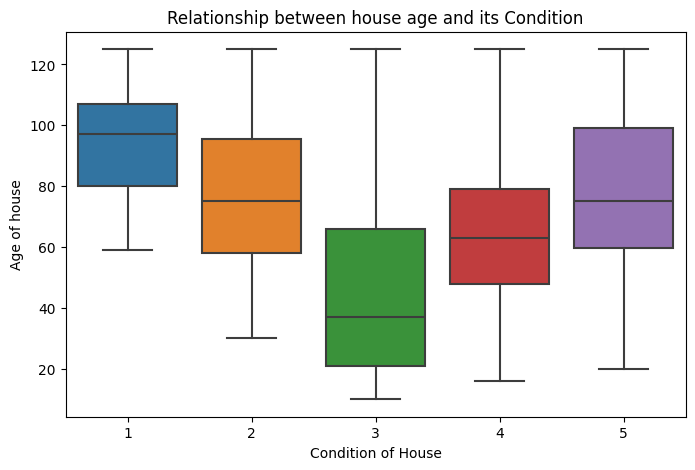

In [19]:
sns.boxplot(data=df, x='condition', y='age_of_house')
plt.xlabel('Condition of House')
plt.ylabel('Age of house')
plt.title('Relationship between house age and its Condition')


Text(0.5, 1.0, 'Relationship between house age and its Condition')

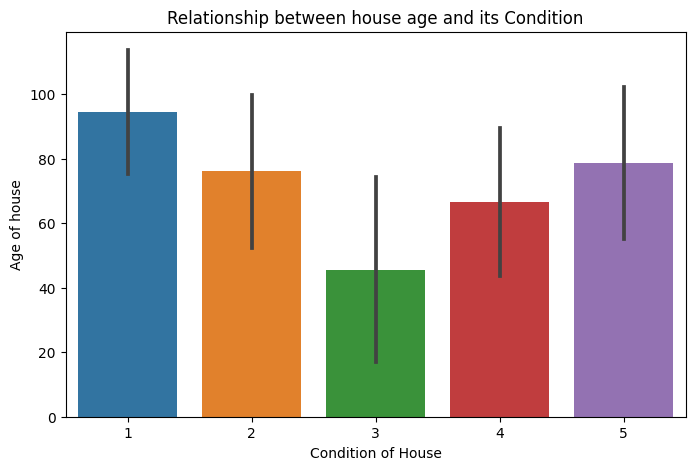

In [20]:
sns.barplot(x='condition', y='age_of_house', data=df, ci='sd')
plt.xlabel('Condition of House')
plt.ylabel('Age of house')
plt.title('Relationship between house age and its Condition')

In [21]:
#Both numeric & you assume equal intervals
print("Pearson:", df['age_of_house'].corr(df['condition'], method='pearson'))

#Categorical (Ordinal) + numeric, monotonic unsure if the steps between grades are perfectly equal - Better choice
print("Spearman:", df['age_of_house'].corr(df['condition'], method='spearman'))

Pearson: 0.3615546839397709
Spearman: 0.39386252851247894


In [24]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopy.distance import geodesic

# Create a geometry point using lat & long
geometry = [Point(xy) for xy in zip(df_sqft_living_sample['long'], df_sqft_living_sample['lat'])]

In [25]:
# Create GeoDataFrame
houses_gdf = gpd.GeoDataFrame(df_sqft_living_sample, geometry=geometry, crs="EPSG:4326") # coordinate reference system's wgs84
houses_gdf.head(3)

,index,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,num_of_views,condition,...,zipcode,lat,long,sqft_living15,sqft_lot15,date,price,grade_class,grade_class_group,geometry
0,0,7129300520,3,1.000,1180.000,5650.000,1.000,False,0,3,...,98178,47.511,-122.257,1340.000,5650.000,2014-10-13,221900,"Average build quality, commonly found in stand...",Medium Grade (6-9),POINT (-122.257 47.5112)
1,1,6414100192,3,2.500,2570.000,7242.000,2.000,False,0,3,...,98125,47.721,-122.319,1690.000,7639.000,2014-12-09,538000,"Average build quality, commonly found in stand...",Medium Grade (6-9),POINT (-122.319 47.721)
2,2,5631500400,2,1.000,770.000,10000.000,1.000,False,0,3,...,98028,47.738,-122.233,2720.000,8062.000,2015-02-25,180000,Meets current code but is still on the low end...,Medium Grade (6-9),POINT (-122.233 47.7379)


In [26]:
# Calculate distance_to_center to seattle city center's lat& long (4)7.6061° N, 122.3328°)
houses_gdf['distance_km'] = houses_gdf.geometry.apply(lambda p: geodesic((p.y, p.x), (47.6061, -122.3328)).km)
houses_gdf.head(3)

,index,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,num_of_views,condition,...,lat,long,sqft_living15,sqft_lot15,date,price,grade_class,grade_class_group,geometry,distance_km
0,0,7129300520,3,1.000,1180.000,5650.000,1.000,False,0,3,...,47.511,-122.257,1340.000,5650.000,2014-10-13,221900,"Average build quality, commonly found in stand...",Medium Grade (6-9),POINT (-122.257 47.5112),11.995
1,1,6414100192,3,2.500,2570.000,7242.000,2.000,False,0,3,...,47.721,-122.319,1690.000,7639.000,2014-12-09,538000,"Average build quality, commonly found in stand...",Medium Grade (6-9),POINT (-122.319 47.721),12.817
2,2,5631500400,2,1.000,770.000,10000.000,1.000,False,0,3,...,47.738,-122.233,2720.000,8062.000,2015-02-25,180000,Meets current code but is still on the low end...,Medium Grade (6-9),POINT (-122.233 47.7379),16.459


In [27]:
# Create a city column to see if it's a city house
houses_gdf['is_urban_1st_ring'] = houses_gdf['distance_km'] <= 15
houses_gdf['is_suburban_2nd_ring'] = (houses_gdf['distance_km'] > 15) & (houses_gdf['distance_km'] <= 30)
houses_gdf['is_rural_3rd_ring'] = houses_gdf['distance_km'] > 30
houses_gdf.head(3)

,index,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,num_of_views,condition,...,sqft_lot15,date,price,grade_class,grade_class_group,geometry,distance_km,is_urban_1st_ring,is_suburban_2nd_ring,is_rural_3rd_ring
0,0,7129300520,3,1.000,1180.000,5650.000,1.000,False,0,3,...,5650.000,2014-10-13,221900,"Average build quality, commonly found in stand...",Medium Grade (6-9),POINT (-122.257 47.5112),11.995,True,False,False
1,1,6414100192,3,2.500,2570.000,7242.000,2.000,False,0,3,...,7639.000,2014-12-09,538000,"Average build quality, commonly found in stand...",Medium Grade (6-9),POINT (-122.319 47.721),12.817,True,False,False
2,2,5631500400,2,1.000,770.000,10000.000,1.000,False,0,3,...,8062.000,2015-02-25,180000,Meets current code but is still on the low end...,Medium Grade (6-9),POINT (-122.233 47.7379),16.459,False,True,False


In [28]:
# 3 new variables
urban_1st = houses_gdf[houses_gdf['is_urban_1st_ring'] == True]
suburban_2nd = houses_gdf[houses_gdf['is_suburban_2nd_ring'] == True]
rural_3rd = houses_gdf[houses_gdf['is_rural_3rd_ring'] == True]
print(f"Urban houses: {len(urban_1st)}")
print(f"Suburban houses: {len(suburban_2nd)}")
print(f"Rural houses: {len(rural_3rd)}")

Urban houses: 9047
Suburban houses: 8068
Rural houses: 3699


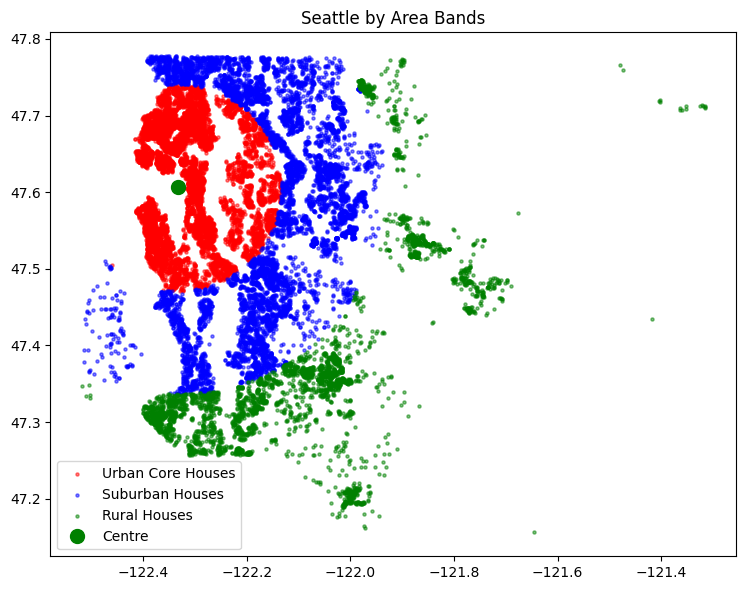

In [29]:
# Visualization of the map
fig, ax = plt.subplots(figsize=(8, 6))
# Red : City houses
urban_1st.plot(ax=ax, color='red', markersize=5, alpha=0.5, label='Urban Core Houses')
# Blue : Suburban houses
suburban_2nd.plot(ax=ax, color='blue', markersize=5, alpha=0.5, label='Suburban Houses')
# Green : Rural houses
rural_3rd.plot(ax=ax, color='green', markersize=5, alpha=0.5, label='Rural Houses')
# Seattle Centre
plt.plot(-122.3321, 47.6062, 'go', markersize=10, label='Centre')
plt.title('Seattle by Area Bands' )
plt.legend()
plt.tight_layout()

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopy.distance import geodesic

# Create a geometry point using lat & long
geometry = [Point(xy) for xy in zip(df['long'], df['lat'])]

# Create GeoDataFrame
houses_gdf2 = gpd.GeoDataFrame(df_sqft_living_sample, geometry=geometry, crs="EPSG:4326") # coordinate reference system's wgs84
# Calculate distance_to_center to seattle city center's lat& long (4)7.6061° N, 122.3328°)
houses_gdf2['distance_km'] = houses_gdf2.geometry.apply(lambda p: geodesic((p.y, p.x), (47.6061, -122.3328)).km)
# Create a city column to see if it's a city house
houses_gdf2['is_urban_1st_ring'] = houses_gdf2['distance_km'] <= 15
houses_gdf2['is_suburban_2nd_ring'] = (houses_gdf2['distance_km'] > 15) & (houses_gdf2['distance_km'] <= 30)
houses_gdf2['is_rural_3rd_ring'] = houses_gdf2['distance_km'] > 30
# 3 new variables
urban_1st = houses_gdf2[houses_gdf2['is_urban_1st_ring'] == True]
suburban_2nd = houses_gdf2[houses_gdf2['is_suburban_2nd_ring'] == True]
rural_3rd = houses_gdf2[houses_gdf2['is_rural_3rd_ring'] == True]
# Visualization of the map
fig, ax = plt.subplots(figsize=(8, 6))
# Red : City houses
urban_1st.plot(ax=ax, color='red', markersize=5, alpha=0.5, label='Urban Core Houses')
# Blue : Suburban houses
suburban_2nd.plot(ax=ax, color='blue', markersize=5, alpha=0.5, label='Suburban Houses')
# Green : Rural houses
rural_3rd.plot(ax=ax, color='green', markersize=5, alpha=0.5, label='Rural Houses')
# Seattle Centre
plt.plot(-122.3321, 47.6062, 'go', markersize=10, label='Centre')
plt.title('Seattle by Area Bands' )
plt.legend()
plt.tight_layout()

In [30]:
zip_to_band = {
    # Urban
    98102: 'urban_1st', 98103: 'urban_1st', 98105: 'urban_1st', 98107: 'urban_1st', 98109: 'urban_1st',
    98112: 'urban_1st', 98115: 'urban_1st', 98116: 'urban_1st', 98117: 'urban_1st', 98118: 'urban_1st',
    98119: 'urban_1st', 98122: 'urban_1st', 98126: 'urban_1st', 98136: 'urban_1st', 98144: 'urban_1st',
    98177: 'urban_1st', 98199: 'urban_1st',
    # Suburban
    98004: 'suburban_2nd', 98005: 'suburban_2nd', 98006: 'suburban_2nd', 98007: 'suburban_2nd', 98008: 'suburban_2nd',
    98011: 'suburban_2nd', 98033: 'suburban_2nd', 98034: 'suburban_2nd', 98039: 'suburban_2nd', 98040: 'suburban_2nd',
    98052: 'suburban_2nd', 98053: 'suburban_2nd', 98072: 'suburban_2nd', 98074: 'suburban_2nd', 98075: 'suburban_2nd',
    98125: 'suburban_2nd', 98155: 'suburban_2nd',
    # Rural
    98001: 'rural_3rd', 98002: 'rural_3rd', 98003: 'rural_3rd', 98010: 'rural_3rd', 98014: 'rural_3rd',
    98019: 'rural_3rd', 98022: 'rural_3rd', 98023: 'rural_3rd', 98024: 'rural_3rd', 98027: 'rural_3rd',
    98028: 'rural_3rd', 98029: 'rural_3rd', 98030: 'rural_3rd', 98031: 'rural_3rd', 98032: 'rural_3rd',
    98038: 'rural_3rd', 98042: 'rural_3rd', 98045: 'rural_3rd', 98055: 'rural_3rd', 98056: 'rural_3rd',
    98058: 'rural_3rd', 98059: 'rural_3rd', 98065: 'rural_3rd', 98070: 'rural_3rd', 98077: 'rural_3rd',
    98092: 'rural_3rd', 98106: 'rural_3rd', 98108: 'rural_3rd', 98133: 'rural_3rd', 98146: 'rural_3rd',
    98148: 'rural_3rd', 98166: 'rural_3rd', 98168: 'rural_3rd', 98178: 'rural_3rd', 98188: 'rural_3rd',
    98198: 'rural_3rd',
}

In [31]:
zip_to_area = {
    # Urban core Seattle ZIPs
    98102: 'Capitol Hill / Eastlake',
    98103: 'Fremont / Wallingford / Green Lake',
    98105: 'UW District / Laurelhurst',
    98107: 'Ballard / Shilshole',
    98109: 'South Lake Union / Queen Anne (lower)',
    98112: 'Madison Park / Washington Park',
    98115: 'Wedgwood / Sand Point',
    98116: 'Alki / West Seattle Beach',
    98117: 'North Ballard / Sunset Hill',
    98118: 'Seward Park / Rainier Beach',
    98119: 'Queen Anne',
    98122: 'Central District / Madison Valley',
    98126: 'Delridge / High Point / West Seattle',
    98136: 'Fauntleroy / Gatewood',
    98144: 'Mount Baker / Judkins Park',
    98177: 'Broadview / Blue Ridge',
    98199: 'Magnolia',

    # Suburban Eastside ZIPs
    98004: 'Downtown Bellevue / Meydenbauer',
    98005: 'Bridle Trails / Wilburton',
    98006: 'Newcastle / Somerset',
    98007: 'Crossroads / East Bellevue',
    98008: 'Lake Hills / Phantom Lake',
    98011: 'Bothell',
    98033: 'Kirkland Downtown',
    98034: 'Juanita / Finn Hill',
    98039: 'Medina',
    98040: 'Mercer Island',
    98052: 'Redmond',
    98053: 'Redmond Ridge / Trilogy',
    98072: 'Woodinville',
    98074: 'Sammamish West',
    98075: 'Sammamish East',
    98125: 'Lake City / Matthews Beach',
    98155: 'Shoreline',

    # Rural/exurban edges
    98001: 'Auburn West',
    98002: 'Auburn',
    98003: 'Federal Way North',
    98010: 'Black Diamond',
    98014: 'Carnation',
    98019: 'Duvall',
    98022: 'Enumclaw',
    98023: 'Federal Way South',
    98024: 'Fall City',
    98027: 'Issaquah South / Cougar Mountain',
    98028: 'Kenmore',
    98029: 'Issaquah Highlands',
    98030: 'Kent East',
    98031: 'Kent North',
    98032: 'Kent West / Industrial',
    98038: 'Maple Valley',
    98042: 'Covington',
    98045: 'North Bend',
    98055: 'Renton East',
    98056: 'Renton Highlands',
    98058: 'Fairwood',
    98059: 'Renton Maplewood',
    98065: 'Snoqualmie',
    98070: 'Vashon Island',
    98077: 'Woodinville Rural',
    98092: 'Auburn South',
    98106: 'Delridge / White Center',
    98108: 'Georgetown / South Park',
    98133: 'Shoreline North',
    98146: 'White Center / Burien North',
    98148: 'Burien West',
    98166: 'Des Moines',
    98168: 'Tukwila / Boulevard Park',
    98178: 'Skyway',
    98188: 'SeaTac',
    98198: 'Des Moines South',
}

In [33]:
df_sqft_living_sample.head()

,index,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,num_of_views,condition,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date,price,grade_class,grade_class_group
0,0,7129300520,3,1.000,1180.000,5650.000,1.000,False,0,3,...,0.000,98178,47.511,-122.257,1340.000,5650.000,2014-10-13,221900,"Average build quality, commonly found in stand...",Medium Grade (6-9)
1,1,6414100192,3,2.500,2570.000,7242.000,2.000,False,0,3,...,19910.000,98125,47.721,-122.319,1690.000,7639.000,2014-12-09,538000,"Average build quality, commonly found in stand...",Medium Grade (6-9)
2,2,5631500400,2,1.000,770.000,10000.000,1.000,False,0,3,...,0.000,98028,47.738,-122.233,2720.000,8062.000,2015-02-25,180000,Meets current code but is still on the low end...,Medium Grade (6-9)
3,3,2487200875,4,3.000,1960.000,5000.000,1.000,False,0,5,...,0.000,98136,47.521,-122.393,1360.000,5000.000,2014-12-09,604000,"Average build quality, commonly found in stand...",Medium Grade (6-9)
4,4,1954400510,3,2.000,1680.000,8080.000,1.000,False,0,3,...,0.000,98074,47.617,-122.045,1800.000,7503.000,2015-02-18,510000,"Slightly above average, better materials and f...",Medium Grade (6-9)


In [35]:
df_sqft_living_sample['urban_band'] = df_sqft_living_sample['zipcode'].map(zip_to_band)
df_sqft_living_sample['area_name'] = df_sqft_living_sample['zipcode'].map(zip_to_area)
houses_gdf.head(5)
houses_gdf.dtypes

index                            int64
id                               int64
bedrooms                         int64
bathrooms                      float64
sqft_living                    float64
sqft_lot                       float64
floors                         float64
waterfront                        bool
num_of_views                     int64
condition                        int64
grade                            int64
sqft_above                     float64
sqft_basement                  float64
yr_built                datetime64[ns]
yr_renovated                   float64
zipcode                          int64
lat                            float64
long                           float64
sqft_living15                  float64
sqft_lot15                     float64
date                    datetime64[ns]
price                            int64
grade_class                     object
grade_class_group               object
geometry                      geometry
distance_km              

In [36]:
df_sqft_living_sample = df_sqft_living_sample.merge(
    houses_gdf[['id', 'geometry', 'distance_km',
               'is_urban_1st_ring', 'is_suburban_2nd_ring', 'is_rural_3rd_ring']],
    on='id',
    how='left'   # keeps all rows in df
)

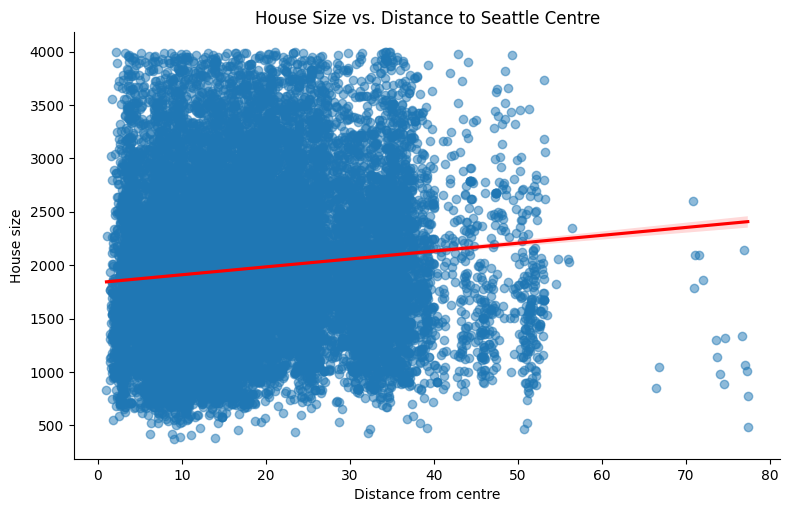

In [37]:
sns.lmplot(
    data=df_sqft_living_sample,
    x='distance_km',
    y='sqft_living',
    line_kws={'color': 'red'},
    scatter_kws={'alpha': 0.5},
    height=5,         # inches
    aspect=8/5       # width / height
)

plt.title('House Size vs. Distance to Seattle Centre')
plt.xlabel('Distance from centre')
plt.ylabel('House size')
plt.show()

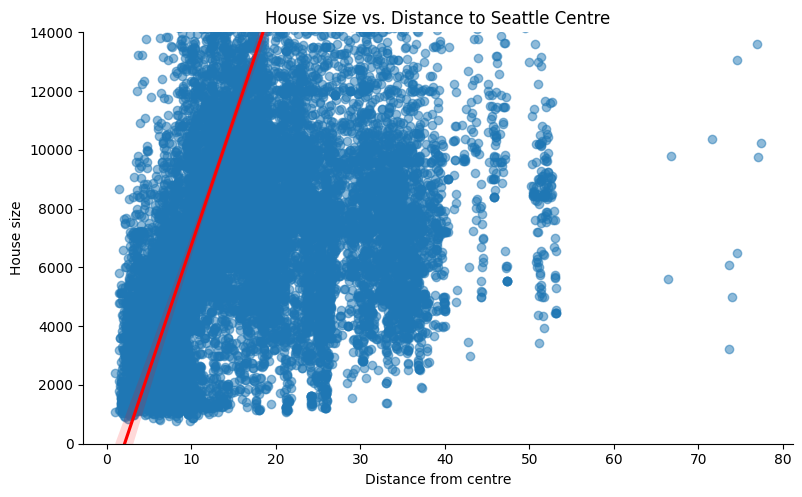

In [39]:
sns.lmplot(
    data=df_sqft_living_sample,
    x='distance_km',
    y='sqft_lot',
    line_kws={'color': 'red'},
    scatter_kws={'alpha': 0.5},
    height=5,         # inches
    aspect=8/5       # width / height
)

plt.ylim(0, 14000)  # show only up to 100,000 sqft
plt.title('House Size vs. Distance to Seattle Centre')
plt.xlabel('Distance from centre')
plt.ylabel('House size')
plt.show()

In [42]:
#sns.scatterplot(data=df, x='distance_km', y='sqft_lot')

#Both numeric & you assume equal intervals
print("Pearson (Distance vs House Size):", df_sqft_living_sample['distance_km'].corr(df_sqft_living_sample['sqft_living'], method='pearson'))
print("Pearson (Distance vs Lot Size):", df_sqft_living_sample['distance_km'].corr(df_sqft_living_sample['sqft_lot'], method='pearson'))
#Categorical (Ordinal) + numeric, monotonic unsure if the steps between grades are perfectly equal - Better choice
print("Spearman (Distance vs House Size):", df_sqft_living_sample['distance_km'].corr(df_sqft_living_sample['sqft_living'], method='spearman'))
print("Spearman (Distance vs Lot Size):", df_sqft_living_sample['distance_km'].corr(df_sqft_living_sample['sqft_lot'], method='spearman'))

Pearson (Distance vs House Size): 0.10621616090601141
Pearson (Distance vs Lot Size): 0.23935502312649637
Spearman (Distance vs House Size): 0.15083090260647108
Spearman (Distance vs Lot Size): 0.45733206081432315


In [43]:
print(f"Urban houses: {len(urban_1st)}")
print(f"Suburban houses: {len(suburban_2nd)}")
print(f"Rural houses: {len(rural_3rd)}")

Urban houses: 9047
Suburban houses: 8068
Rural houses: 3699


In [44]:
avg_size_by_area = df_sqft_living_sample.groupby('urban_band')['sqft_living'].mean().reset_index()
avg_size_by_area

,urban_band,sqft_living
0,rural_3rd,1931.400
1,suburban_2nd,2234.732
2,urban_1st,1791.849


In [52]:
avg_size_by_area = df_sqft_living_sample.groupby('urban_band')['sqft_lot'].mean().reset_index()
avg_size_by_area

,urban_band,sqft_lot
0,rural_3rd,19343.971
1,suburban_2nd,13301.458
2,urban_1st,4860.048


In [47]:
df_sqft_living_sample

,index,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,num_of_views,condition,...,price,grade_class,grade_class_group,urban_band,area_name,geometry,distance_km,is_urban_1st_ring,is_suburban_2nd_ring,is_rural_3rd_ring
0,0,7129300520,3,1.000,1180.000,5650.000,1.000,False,0,3,...,221900,"Average build quality, commonly found in stand...",Medium Grade (6-9),rural_3rd,Skyway,POINT (-122.257 47.5112),11.995,True,False,False
1,1,6414100192,3,2.500,2570.000,7242.000,2.000,False,0,3,...,538000,"Average build quality, commonly found in stand...",Medium Grade (6-9),suburban_2nd,Lake City / Matthews Beach,POINT (-122.319 47.721),12.817,True,False,False
2,2,5631500400,2,1.000,770.000,10000.000,1.000,False,0,3,...,180000,Meets current code but is still on the low end...,Medium Grade (6-9),rural_3rd,Kenmore,POINT (-122.233 47.7379),16.459,False,True,False
3,3,2487200875,4,3.000,1960.000,5000.000,1.000,False,0,5,...,604000,"Average build quality, commonly found in stand...",Medium Grade (6-9),urban_1st,Fauntleroy / Gatewood,POINT (-122.393 47.5208),10.510,True,False,False
4,4,1954400510,3,2.000,1680.000,8080.000,1.000,False,0,3,...,510000,"Slightly above average, better materials and f...",Medium Grade (6-9),suburban_2nd,Sammamish West,POINT (-122.045 47.6168),21.671,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21159,21592,263000018,3,2.500,1530.000,1530.000,3.000,False,0,3,...,360000,"Slightly above average, better materials and f...",Medium Grade (6-9),urban_1st,Fremont / Wallingford / Green Lake,POINT (-122.346 47.6993),10.410,True,False,False
21160,21593,6600060120,4,2.500,2310.000,5813.000,2.000,False,0,3,...,400000,"Slightly above average, better materials and f...",Medium Grade (6-9),rural_3rd,White Center / Burien North,POINT (-122.362 47.5107),10.832,True,False,False
21161,21594,1523300141,2,1.000,1020.000,1350.000,2.000,False,0,3,...,402101,"Average build quality, commonly found in stand...",Medium Grade (6-9),urban_1st,Mount Baker / Judkins Park,POINT (-122.299 47.5944),2.855,True,False,False
21162,21595,291310100,3,2.500,1600.000,2388.000,2.000,False,0,3,...,400000,"Slightly above average, better materials and f...",Medium Grade (6-9),rural_3rd,Issaquah South / Cougar Mountain,POINT (-122.069 47.5345),21.386,False,True,False


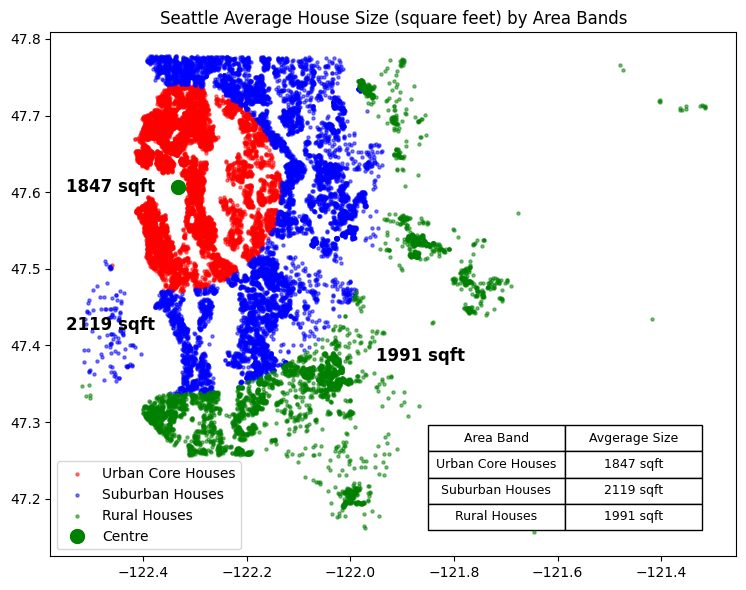

In [48]:
avg_size = houses_gdf.groupby(
    ['is_urban_1st_ring', 'is_suburban_2nd_ring', 'is_rural_3rd_ring']
)['sqft_living'].mean()

urban_avg = avg_size[True, False, False]
suburban_avg = avg_size[False, True, False]
rural_avg = avg_size[False, False, True]

fig, ax = plt.subplots(figsize=(8, 6))

urban_1st.plot(ax=ax, color='red', markersize=5, alpha=0.5, label='Urban Core Houses')
suburban_2nd.plot(ax=ax, color='blue', markersize=5, alpha=0.5, label='Suburban Houses')
rural_3rd.plot(ax=ax, color='green', markersize=5, alpha=0.5, label='Rural Houses')

plt.plot(-122.3321, 47.6062, 'go', markersize=10, label='Centre')

# Add table
table_data = [
    ['Urban Core Houses', f"{urban_avg:.0f} sqft"],
    ['Suburban Houses', f"{suburban_avg:.0f} sqft"],
    ['Rural Houses', f"{rural_avg:.0f} sqft"]
]

table = ax.table(
    cellText=table_data,
    colLabels=['Area Band', 'Avgerage Size'],
    cellLoc='center',
    loc='lower right',
    bbox=[0.55, 0.05, 0.40, 0.20]
)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.5)

# Add average labels
ax.text(-122.55, 47.60, f"{urban_avg:.0f} sqft", color='black', fontsize=12, fontweight='bold')
ax.text(-122.55, 47.42, f"{suburban_avg:.0f} sqft", color='black', fontsize=12, fontweight='bold')
ax.text(-121.95, 47.38, f"{rural_avg:.0f} sqft", color='black', fontsize=12, fontweight='bold')

plt.title('Seattle Average House Size (square feet) by Area Bands')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
avg_size = houses_gdf.groupby(
    ['is_urban_1st_ring', 'is_suburban_2nd_ring', 'is_rural_3rd_ring']
)['sqft_lot'].mean()

urban_avg = avg_size[True, False, False]
suburban_avg = avg_size[False, True, False]
rural_avg = avg_size[False, False, True]

fig, ax = plt.subplots(figsize=(8, 6))

urban_1st.plot(ax=ax, color='red', markersize=5, alpha=0.5, label='Urban Core Houses')
suburban_2nd.plot(ax=ax, color='blue', markersize=5, alpha=0.5, label='Suburban Houses')
rural_3rd.plot(ax=ax, color='green', markersize=5, alpha=0.5, label='Rural Houses')

plt.plot(-122.3321, 47.6062, 'go', markersize=10, label='Centre')

# Add table
table_data = [
    ['Urban Core Houses', f"{urban_avg:.0f} sqft"],
    ['Suburban Houses', f"{suburban_avg:.0f} sqft"],
    ['Rural Houses', f"{rural_avg:.0f} sqft"]
]

table = ax.table(
    cellText=table_data,
    colLabels=['Area Band', 'Avgerage Size'],
    cellLoc='center',
    loc='lower right',
    bbox=[0.55, 0.05, 0.40, 0.20]
)

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.5)

# Add average labels
ax.text(-122.55, 47.60, f"{urban_avg:.0f} sqft", color='black', fontsize=12, fontweight='bold')
ax.text(-122.55, 47.42, f"{suburban_avg:.0f} sqft", color='black', fontsize=12, fontweight='bold')
ax.text(-121.95, 47.38, f"{rural_avg:.0f} sqft", color='black', fontsize=12, fontweight='bold')

plt.title('Seattle Average House Size (square feet) by Area Bands')
plt.legend()
plt.tight_layout()
plt.show()

In [50]:
df_sqft_living_sample.head()

,index,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,num_of_views,condition,...,price,grade_class,grade_class_group,urban_band,area_name,geometry,distance_km,is_urban_1st_ring,is_suburban_2nd_ring,is_rural_3rd_ring
0,0,7129300520,3,1.000,1180.000,5650.000,1.000,False,0,3,...,221900,"Average build quality, commonly found in stand...",Medium Grade (6-9),rural_3rd,Skyway,POINT (-122.257 47.5112),11.995,True,False,False
1,1,6414100192,3,2.500,2570.000,7242.000,2.000,False,0,3,...,538000,"Average build quality, commonly found in stand...",Medium Grade (6-9),suburban_2nd,Lake City / Matthews Beach,POINT (-122.319 47.721),12.817,True,False,False
2,2,5631500400,2,1.000,770.000,10000.000,1.000,False,0,3,...,180000,Meets current code but is still on the low end...,Medium Grade (6-9),rural_3rd,Kenmore,POINT (-122.233 47.7379),16.459,False,True,False
3,3,2487200875,4,3.000,1960.000,5000.000,1.000,False,0,5,...,604000,"Average build quality, commonly found in stand...",Medium Grade (6-9),urban_1st,Fauntleroy / Gatewood,POINT (-122.393 47.5208),10.510,True,False,False
4,4,1954400510,3,2.000,1680.000,8080.000,1.000,False,0,3,...,510000,"Slightly above average, better materials and f...",Medium Grade (6-9),suburban_2nd,Sammamish West,POINT (-122.045 47.6168),21.671,False,True,False


Text(0.5, 0, 'Area Band')

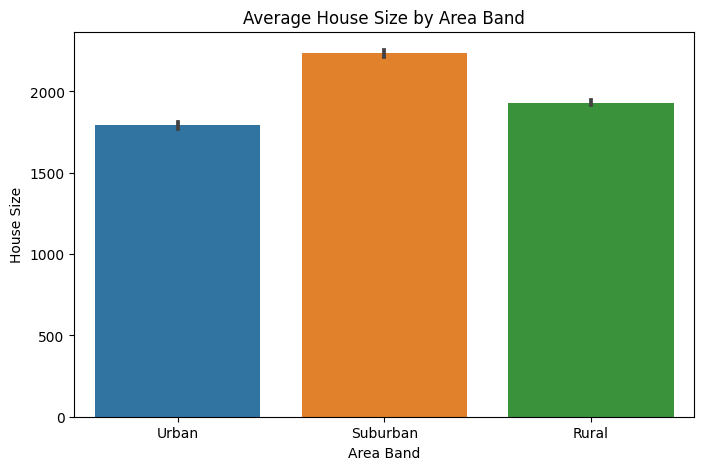

In [62]:
ax = sns.barplot(data=df_sqft_living_sample, x='urban_band', y='sqft_living', order=['urban_1st', 'suburban_2nd', 'rural_3rd'])

ax.set_xticklabels(['Urban', 'Suburban', 'Rural'])
plt.title('Average House Size by Area Band')
plt.ylabel('House Size')
plt.xlabel('Area Band')

In [99]:
#CLIENT NICOLE
#1 - LIVELY NEIGHBOURHOOD

lively_zips = [98101, 98102, 98103, 98105, 98107, 98109, 98112, 98119, 98121, 98122]
lively_df_sample = df_sqft_living_sample[df_sqft_living_sample['zipcode'].isin(lively_zips)]


In [ ]:
lively_df
#There are 2008 rows

,index,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,num_of_views,condition,...,price,grade_class,grade_class_group,urban_band,area_name,geometry,distance_km,is_urban_1st_ring,is_suburban_2nd_ring,is_rural_3rd_ring
13,14,1175000570,5,2.000,1810.000,4850.000,1.500,False,0,3,...,530000,"Average build quality, commonly found in stand...",Medium Grade (6-9),urban_1st,Ballard / Shilshole,POINT (-122.394 47.67),8.463,True,False,False
16,17,6865200140,4,1.000,1600.000,4300.000,1.500,False,0,4,...,485000,"Average build quality, commonly found in stand...",Medium Grade (6-9),urban_1st,Fremont / Wallingford / Green Lake,POINT (-122.343 47.6648),6.571,True,False,False
25,26,1794500383,3,2.000,2450.000,2691.000,2.000,False,0,3,...,937000,"Slightly above average, better materials and f...",Medium Grade (6-9),urban_1st,Queen Anne,POINT (-122.36 47.6386),4.152,True,False,False
26,27,3303700376,3,1.000,1400.000,1581.000,1.500,False,0,5,...,667000,"Slightly above average, better materials and f...",Medium Grade (6-9),urban_1st,Madison Park / Washington Park,POINT (-122.314 47.6221),2.272,True,False,False
36,37,2768000400,4,2.000,2360.000,6000.000,2.000,False,0,4,...,640000,"Slightly above average, better materials and f...",Medium Grade (6-9),urban_1st,Ballard / Shilshole,POINT (-122.362 47.6702),7.457,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21137,21567,2025049203,2,1.000,710.000,1157.000,2.000,True,0,4,...,399950,"Average build quality, commonly found in stand...",Medium Grade (6-9),urban_1st,Capitol Hill / Eastlake,POINT (-122.329 47.6413),3.924,True,False,False
21140,21570,2767604724,2,2.500,1430.000,1430.000,3.000,False,0,3,...,505000,"Slightly above average, better materials and f...",Medium Grade (6-9),urban_1st,Ballard / Shilshole,POINT (-122.381 47.6707),8.044,True,False,False
21145,21576,1931300412,3,2.500,1190.000,1200.000,3.000,False,0,3,...,475000,"Slightly above average, better materials and f...",Medium Grade (6-9),urban_1st,Fremont / Wallingford / Green Lake,POINT (-122.346 47.6542),5.439,True,False,False
21147,21579,1972201967,2,2.500,1530.000,1530.000,3.000,False,0,3,...,520000,"Slightly above average, better materials and f...",Medium Grade (6-9),urban_1st,Fremont / Wallingford / Green Lake,POINT (-122.346 47.6533),5.341,True,False,False


In [109]:
lively_df_sample.groupby('area_name')['price'].mean().sort_values().round(0)

area_name
Ballard / Shilshole                     558899.000
Fremont / Wallingford / Green Lake      569754.000
Central District / Madison Valley       580152.000
UW District / Laurelhurst               671308.000
Capitol Hill / Eastlake                 707213.000
Queen Anne                              708382.000
South Lake Union / Queen Anne (lower)   717316.000
Madison Park / Washington Park          765073.000
Name: price, dtype: float64

In [108]:
lively_df_sample['price'].describe()

count      1837.000
mean     625055.174
std      194797.437
min      169317.000
25%      485000.000
50%      595000.000
75%      739000.000
max     1200000.000
Name: price, dtype: float64

In [135]:
lively_df['short_area_name'] = lively_df['area_name'].map({
    'Ballard / Shilshole': 'Ballard',
    'Fremont / Wallingford / Green Lake': 'Fremont',
    'Central District / Madison Valley': 'Central Dist.',
    'Capitol Hill / Eastlake': 'Capitol Hill',
    'UW District / Laurelhurst': 'UW Dist.',
    'Queen Anne': 'Queen Anne',
    'South Lake Union / Queen Anne (lower)': 'SLU',
    'Madison Park / Washington Park': 'Madison Park',
})

In [107]:
lively_df['price'].sort_values()

1588      169317
3901      202000
11241     216650
3760      216650
12275     238000
          ...   
5500     2400000
7349     2500000
1396     2540000
7278     2580000
18241    2950000
Name: price, Length: 2008, dtype: int64

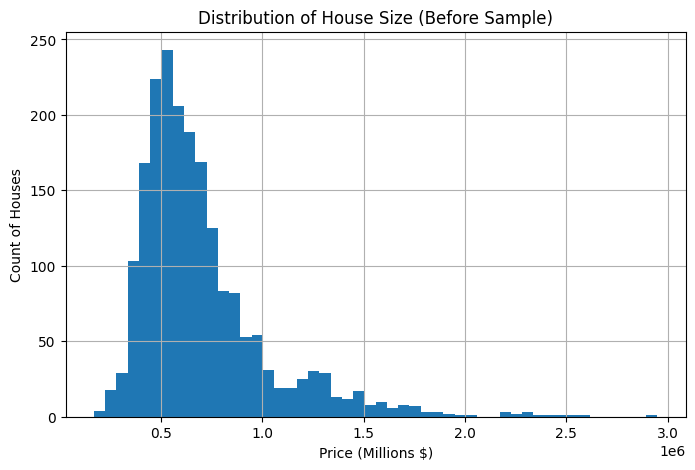

In [106]:
plt.figure(figsize=(8, 5))
lively_df['price'].hist(bins=50)
plt.xlabel('Price (Millions $)')
plt.ylabel('Count of Houses')
plt.title('Distribution of House Size (Before Sample)')
plt.show()

In [137]:
# Define your lower & upper bounds
lower = 100000
upper = 1200000
# Filter the DataFrame
lively_df_sample = lively_df[(lively_df['price'] >= lower) & (lively_df['price'] <= upper)].reset_index()
print(f"Original rows: {len(lively_df)}")
print(f"Sample rows: {len(lively_df_sample)}")
print((len(lively_df_sample)/len(lively_df))*100)

Original rows: 2008
Sample rows: 1837
91.48406374501991


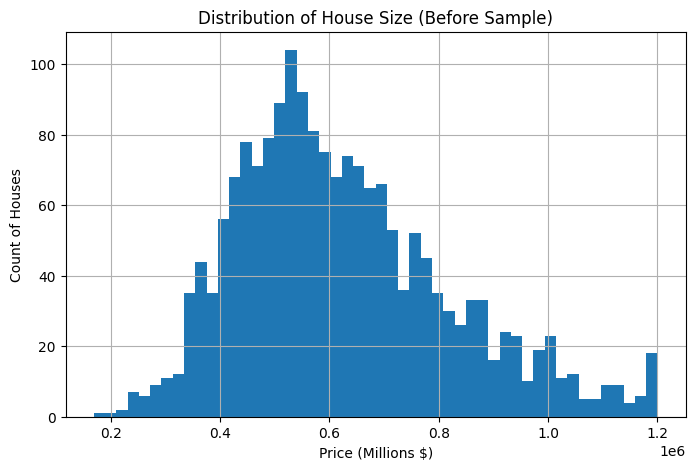

In [103]:
plt.figure(figsize=(8, 5))
lively_df_sample['price'].hist(bins=50)
plt.xlabel('Price (Millions $)')
plt.ylabel('Count of Houses')
plt.title('Distribution of House Size (Before Sample)')
plt.show()

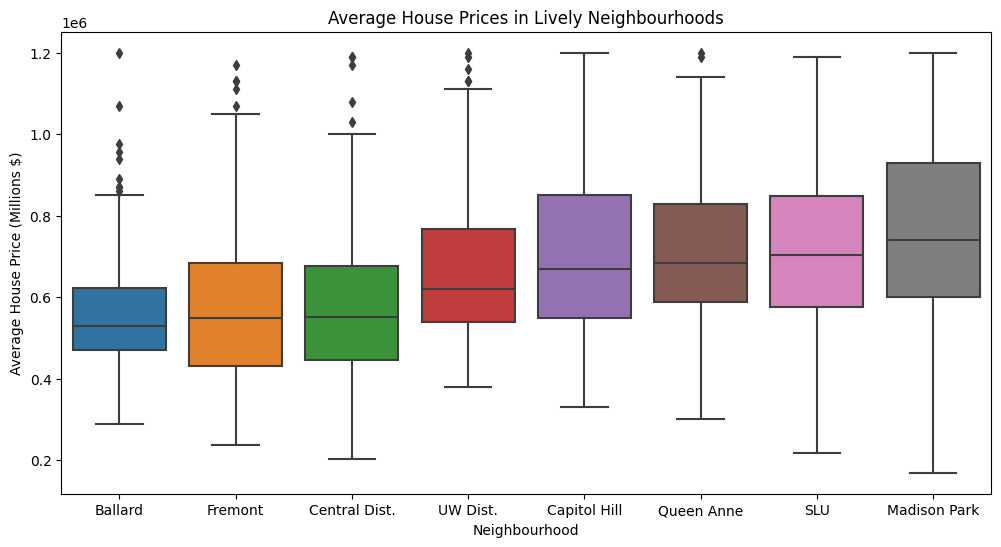

In [140]:
order = (
    lively_df_sample.groupby('short_area_name')['price']
    .mean()
    .sort_values()
    .index
)


plt.figure(figsize=(12, 6))
sns.boxplot(
    data=lively_df_sample,
    x='short_area_name',
    y='price',
    order=order  # ordered by mean price ascending
)
#plt.ylim(0, 960567.0)
plt.xlabel('Neighbourhood')
plt.ylabel('Average House Price (Millions $)')
plt.title('Average House Prices in Lively Neighbourhoods')
plt.xticks(ha='center')
plt.show()

In [113]:
lively_df_sample.groupby('area_name')['zipcode'].unique()


area_name
Ballard / Shilshole                      [98107]
Capitol Hill / Eastlake                  [98102]
Central District / Madison Valley        [98122]
Fremont / Wallingford / Green Lake       [98103]
Madison Park / Washington Park           [98112]
Queen Anne                               [98119]
South Lake Union / Queen Anne (lower)    [98109]
UW District / Laurelhurst                [98105]
Name: zipcode, dtype: object

In [141]:
lively_affordable_zips = [98103, 98122]
Lively_affordable = lively_df_sample[lively_df_sample['zipcode'].isin(lively_affordable_zips)]
Lively_affordable

,level_0,index,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,num_of_views,...,grade_class,grade_class_group,urban_band,area_name,geometry,distance_km,is_urban_1st_ring,is_suburban_2nd_ring,is_rural_3rd_ring,short_area_name
1,16,17,6865200140,4,1.000,1600.000,4300.000,1.500,False,0,...,"Average build quality, commonly found in stand...",Medium Grade (6-9),urban_1st,Fremont / Wallingford / Green Lake,POINT (-122.343 47.6648),6.571,True,False,False,Fremont
8,62,64,1189001180,3,2.500,1660.000,6000.000,1.000,False,0,...,"Average build quality, commonly found in stand...",Medium Grade (6-9),urban_1st,Central District / Madison Valley,POINT (-122.297 47.6113),2.753,True,False,False,Central Dist.
11,110,111,3362400511,3,2.000,1260.000,3328.000,1.000,False,0,...,Meets current code but is still on the low end...,Medium Grade (6-9),urban_1st,Fremont / Wallingford / Green Lake,POINT (-122.349 47.6823),8.559,True,False,False,Fremont
12,114,116,3362400431,3,3.500,1590.000,1590.000,3.000,False,0,...,"Slightly above average, better materials and f...",Medium Grade (6-9),urban_1st,Fremont / Wallingford / Green Lake,POINT (-122.347 47.6824),8.550,True,False,False,Fremont
13,126,128,2331300505,5,3.500,2320.000,4960.000,2.000,False,0,...,"Average build quality, commonly found in stand...",Medium Grade (6-9),urban_1st,Fremont / Wallingford / Green Lake,POINT (-122.352 47.6763),7.937,True,False,False,Fremont
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1829,21120,21551,9521100031,3,3.500,1540.000,1540.000,3.000,False,0,...,Enhanced architectural design with improved in...,Medium Grade (6-9),urban_1st,Fremont / Wallingford / Green Lake,POINT (-122.353 47.6648),6.701,True,False,False,Fremont
1830,21127,21558,1931300090,3,3.000,1680.000,1680.000,3.000,False,0,...,"Slightly above average, better materials and f...",Medium Grade (6-9),urban_1st,Fremont / Wallingford / Green Lake,POINT (-122.346 47.6572),5.767,True,False,False,Fremont
1834,21145,21576,1931300412,3,2.500,1190.000,1200.000,3.000,False,0,...,"Slightly above average, better materials and f...",Medium Grade (6-9),urban_1st,Fremont / Wallingford / Green Lake,POINT (-122.346 47.6542),5.439,True,False,False,Fremont
1835,21147,21579,1972201967,2,2.500,1530.000,1530.000,3.000,False,0,...,"Slightly above average, better materials and f...",Medium Grade (6-9),urban_1st,Fremont / Wallingford / Green Lake,POINT (-122.346 47.6533),5.341,True,False,False,Fremont


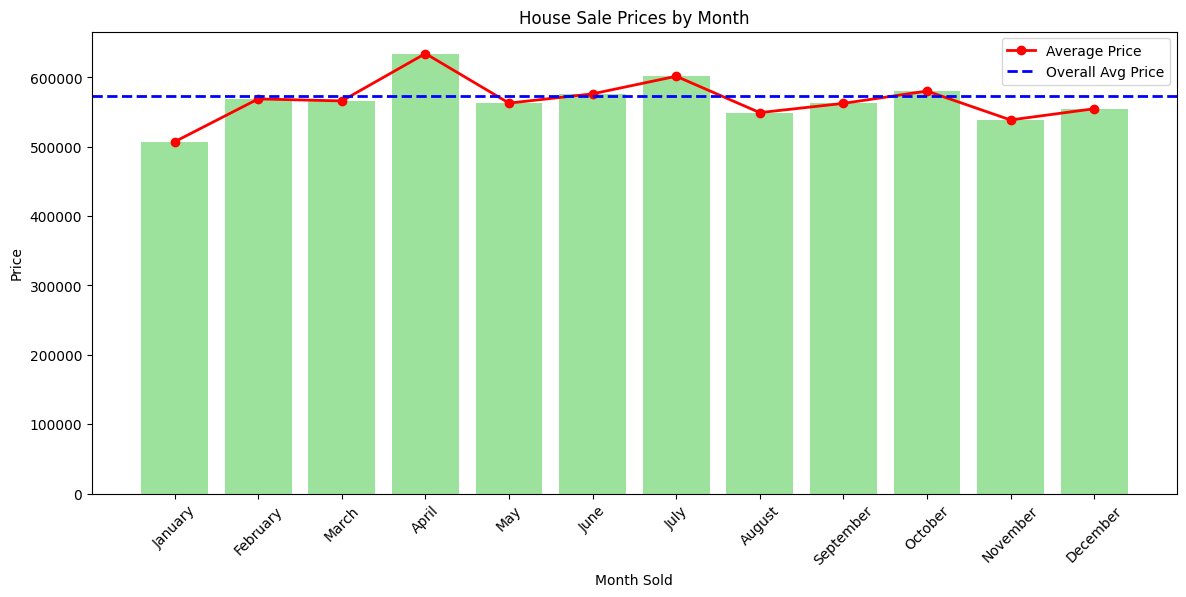

In [ ]:
# sort data frame based on date 
#df_house_cl_time = df_house_cl.sort_values(axis="index", by=["date"])
#df_house_cl_time.reset_index(drop=True, inplace=True)

# create bins for the time the houses were sold
#df_house_cl_time.date = pd.to_datetime(df_house_cl_time.date)  # not really necessary

Lively_affordable["months_sold"] = Lively_affordable["date"].dt.month  # extract months as int to new column
months_labels = ["January", "February", "March", "April", "May", "June",
                 "July", "August", "September", "October", "November", "December"]

Lively_affordable["month_bins"] = pd.cut(Lively_affordable["months_sold"], bins=range(1, 14), labels=months_labels, right=False)

# Calculate overall average price if not already defined
avg_price = Lively_affordable['price'].mean()

plt.figure(figsize=(14, 6))
# Plot average price per month_bin as bars
sns.barplot(
    x='month_bins',
    y='price',
    data=Lively_affordable,
    color='lightgreen',
    ci=None,
    estimator=np.mean
)

# Overlay average price per month_bin as a line
monthly_avg = Lively_affordable.groupby('month_bins')['price'].mean().reindex(months_labels)
plt.plot(months_labels, monthly_avg.values, color='red', marker='o', linewidth=2, label='Average Price')
# Overlay a horizontal line for the overall average price
plt.axhline(avg_price, color='blue', linestyle='--', linewidth=2, label='Overall Avg Price')

plt.xlabel('Month Sold')
plt.ylabel('Price')
plt.title('House Sale Prices by Month')
plt.xticks(rotation=45)
plt.legend()
plt.show()

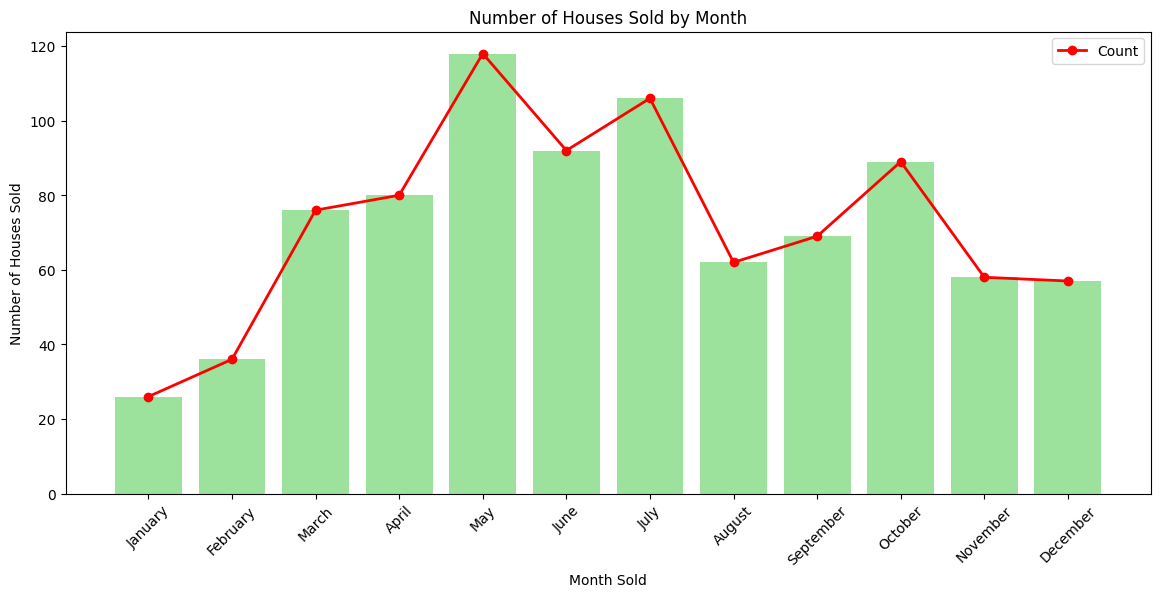

In [143]:
monthly_counts = Lively_affordable.groupby('month_bins').size().reindex(months_labels)

plt.figure(figsize=(14, 6))
sns.countplot(
    x='month_bins',
    data=Lively_affordable,
    color='lightgreen',
    order=months_labels
)

plt.plot(months_labels, monthly_counts.values, color='red', marker='o', linewidth=2, label='Count')

plt.xlabel('Month Sold')
plt.ylabel('Number of Houses Sold')
plt.title('Number of Houses Sold by Month')
plt.xticks(rotation=45)
plt.legend()
plt.show()


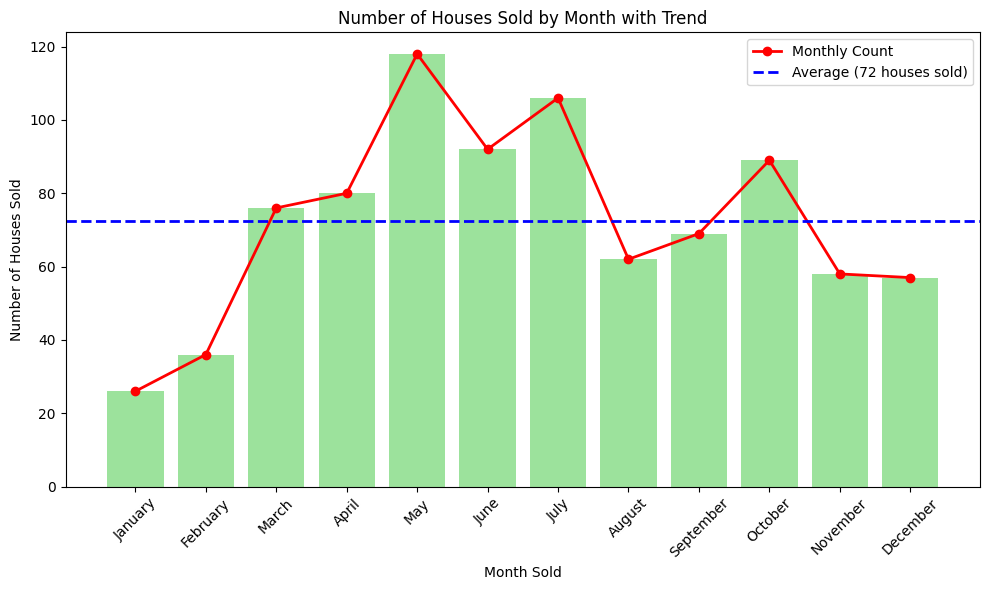

In [149]:
import matplotlib.pyplot as plt
import seaborn as sns

months_labels = ["January", "February", "March", "April", "May", "June",
                 "July", "August", "September", "October", "November", "December"]

# Get counts
monthly_counts = (
    Lively_affordable['month_bins']
    .value_counts()
    .reindex(months_labels)
)

# Average count
mean_count = monthly_counts.mean()

plt.figure(figsize=(10, 6))

# Bars
sns.barplot(
    x=monthly_counts.index,
    y=monthly_counts.values,
    color='lightgreen'
)

# Trend line
plt.plot(
    months_labels,
    monthly_counts.values,
    color='red',
    marker='o',
    linewidth=2,
    label='Monthly Count'
)

# Average line (optional)
plt.axhline(
    mean_count,
    color='blue',
    linestyle='--',
    linewidth=2,
    label=f'Average ({mean_count:.0f} houses sold)'
)

# Labels etc.
plt.xlabel('Month Sold')
plt.ylabel('Number of Houses Sold')
plt.title('Number of Houses Sold by Month with Trend')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
